<h1 align='center'>Neural Networks and Deep Learning</h1>
<img align='right' src='https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova.png' alt='Drawing' width='300'>


<h2 align='left'>Homework 2 - Unsupervised Deep Learning</h2>


<h3 align='left'>University of Padua - Physics of Data</h3>
<h4 align='left'>Dott. Alberto Testolin, Dott. Umberto Micheli</h4>

**Name** | **ID number** | **mail**@studenti.unipd.it
:-:|:-:|-:
Samuele Piccinelli | 2027650 | samuele.piccinelli

<a id='index'></a>
### Index

#### 1. [Introduction and dataset](#1)
#### 2. [Class and callbacks definitions](#2)
#### 3. [First training example and sample generation](#3)
#### 4. [Hyperparameter optimization: Optuna](#4)
#### 5. [Training with the best found model](#5)
#### 6. [Latent space visualization](#6)
#### 7. [Fine-tuning to a supervised task](#7)
#### 8. [Variational autoencoder](#8)
#### 9. [Conclusion](#9)

In this work we implement and test a particular class of neural network models for solving unsupervised problems, namely (convolutional) autoencoders. For simplicity and to allow continuity with the kind of data we have seen in the previous homework, the task is based on images of the `FashionMNIST` dataset.

The notebook is divided in several parts: first, we test and analyze a convolutional autoencoder model, exploring the use of advanced optimizers and regularization methods. Learning hyperparameters are tuned automatically via the [Optuna library](https://optuna.org/).<br>
Successively, we fine-tune the convolutional autoencoder with the best learned hyperparameters using a supervised classification task, and compare classification accuracy and learning speed with results achieved in the first homework, showing that autoencoders can be useful for training supervised models more quickly.<br>
Finally, we implement and test a variational (convolutional) autoencoder.<br>
For both the standard and variational configurations, we generate new samples from latent codes and explore the latent space structure via PCA and t-SNE.

All networks are implemented using the [PyTorch Lightning library](https://www.pytorchlightning.ai/).

<a id='1'></a>
[Index](#index)
### 1. Introduction and dataset

The dataset is the same used for the classification task of the previous homework; the training set ($60$k examples) is split in a fixed 80/20 ratio for validation. This choice is motivated by the fact that the size of the validation dataset is in this case enough for estimating the generalization performance: a $k$-fold CV approach would result in $k$ (almost) equal losses, with no statistical significance nor advantage.<br>
A separate dataset ($10$k examples) is used for the final testing.

In [1]:
# Import useful libraries and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import random
from typing import Tuple, Optional
import warnings

# Import torch + lightning + optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST as MNIST
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torchmetrics

import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [2]:
print('Torch version:', torch.__version__)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {device} for training/testing')

Torch version: 1.10.0
Using cuda for training/testing


The code for loading the data is taken from the previous exercise. The implementation of the `FashionMNISTDataModule` is adapted from [this GitHub repository](https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_lightning_simple.py). Data are scaled in $[0,1]$ to aid the autoencoder classification. The transformations in input are applied to both the full MNIST dataset and the test dataset.

We implement a `show_example` functions that plots a $(5\times 5)$ grid of random samples, along with their identifying label and corresponding tag.

A `FashionMNISTDataModule` is defined: Lightning allows to set more than one `DataLoader` in the `LightningDataModule`, using the correct one under-the-hood.

In [3]:
MNIST_MEAN = 0.1307
MNIST_STD  = 0.3081

class FastMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Scale data to [0,1]
        self.data = self.data.unsqueeze(1).float().div(255)

        # Put both data and targets on GPU in advance
        self.data, self.targets = self.data.to(device), self.targets.to(device)

    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]

        return img, target

In [4]:
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str='data/MNIST', batch_size : int=64,
                 train_transf : 'transforms'=transforms.ToTensor(), test_transf : 'transforms'=transforms.ToTensor()):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = train_transf
        self.test_transform = test_transf

    def setup(self, stage: Optional[str] = None) -> None:
        self.mnist_full = FastMNIST(self.data_dir, train=True, download=True, transform=self.train_transform)
        self.mnist_test = FastMNIST(self.data_dir, train=False, download=True, transform=self.test_transform)
        
        # Train/Validation split (80/20)
        n_samples = len(self.mnist_full)
        n_train   = int(0.8 * n_samples)

        self.mnist_train, self.mnist_val = random_split(self.mnist_full, [n_train, n_samples-n_train])

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.mnist_train, batch_size=self.batch_size, shuffle=True,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.mnist_val, batch_size=self.batch_size, shuffle=False,
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            self.mnist_test, batch_size=self.batch_size, shuffle=False,
        )

In [5]:
mnist_labels = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

def show_example(ds):
    fig, axs = plt.subplots(5, 5, figsize=(8,8))
    for ax in axs.flatten():
        idx = np.random.randint(0, len(ds))
        img, label = ds[idx]
        img = img.cpu().numpy()
        img = img.reshape(28, 28)
        ax.imshow(np.array(img), cmap='gist_gray')
        ax.set_title(f'{mnist_labels[int(label)]} [{label}]')
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

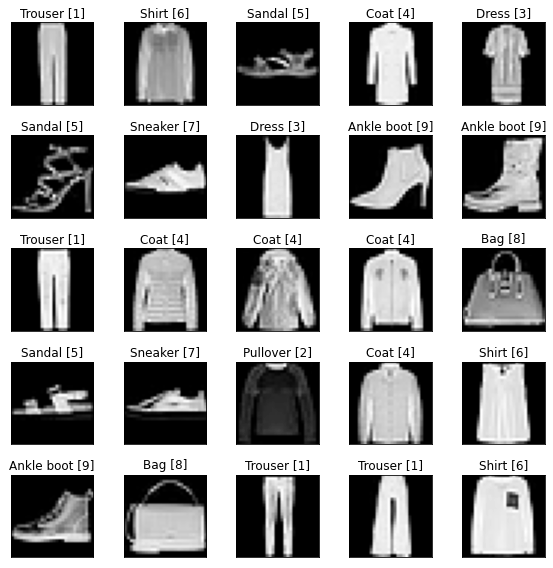

In [6]:
mnist = FashionMNISTDataModule()
mnist.setup()

show_example(mnist.mnist_train)

In [7]:
sample, _ = mnist.mnist_train[1]
print('Normalization check:')
print(f'  min: {torch.min(sample)}, max: {torch.max(sample)}')

Normalization check:
  min: 0.0, max: 1.0


<a id='2'></a>
[Index](#index)
### 2. Class and callbacks definitions

We define here the architecture for the convolutional autoencoder: the encoder and decoder block mirror each other. Each of them consists of a 3-layers convolutional segment followed by 2 fully connected layers. ReLU activation function and dropout regularization are applied after each layer. In this regard, the difference between the `Dropout` and `Dropout2d` layer below is that the former works on input tensors of any shape while the latter is a spatial-dropout designed for 4-D tensors - such as images or feature maps from convolution layers. In such cases, the adjacent features might be strongly correlated and standard dropout would not able to effectively regularize the network. `Dropout2d` cures this issue, effectively ensuring that adjacent pixels are either all $0$s or they are all active.

The encoder's output has no activations and a sigmoid is applied to the decoder block to force the output to be in the $[0, 1]$ interval, i.e. assume valid pixel values. $\mathrm{MSE}$ is used as a loss function.

A visual representation of the network's encoder is showed in the picture below.

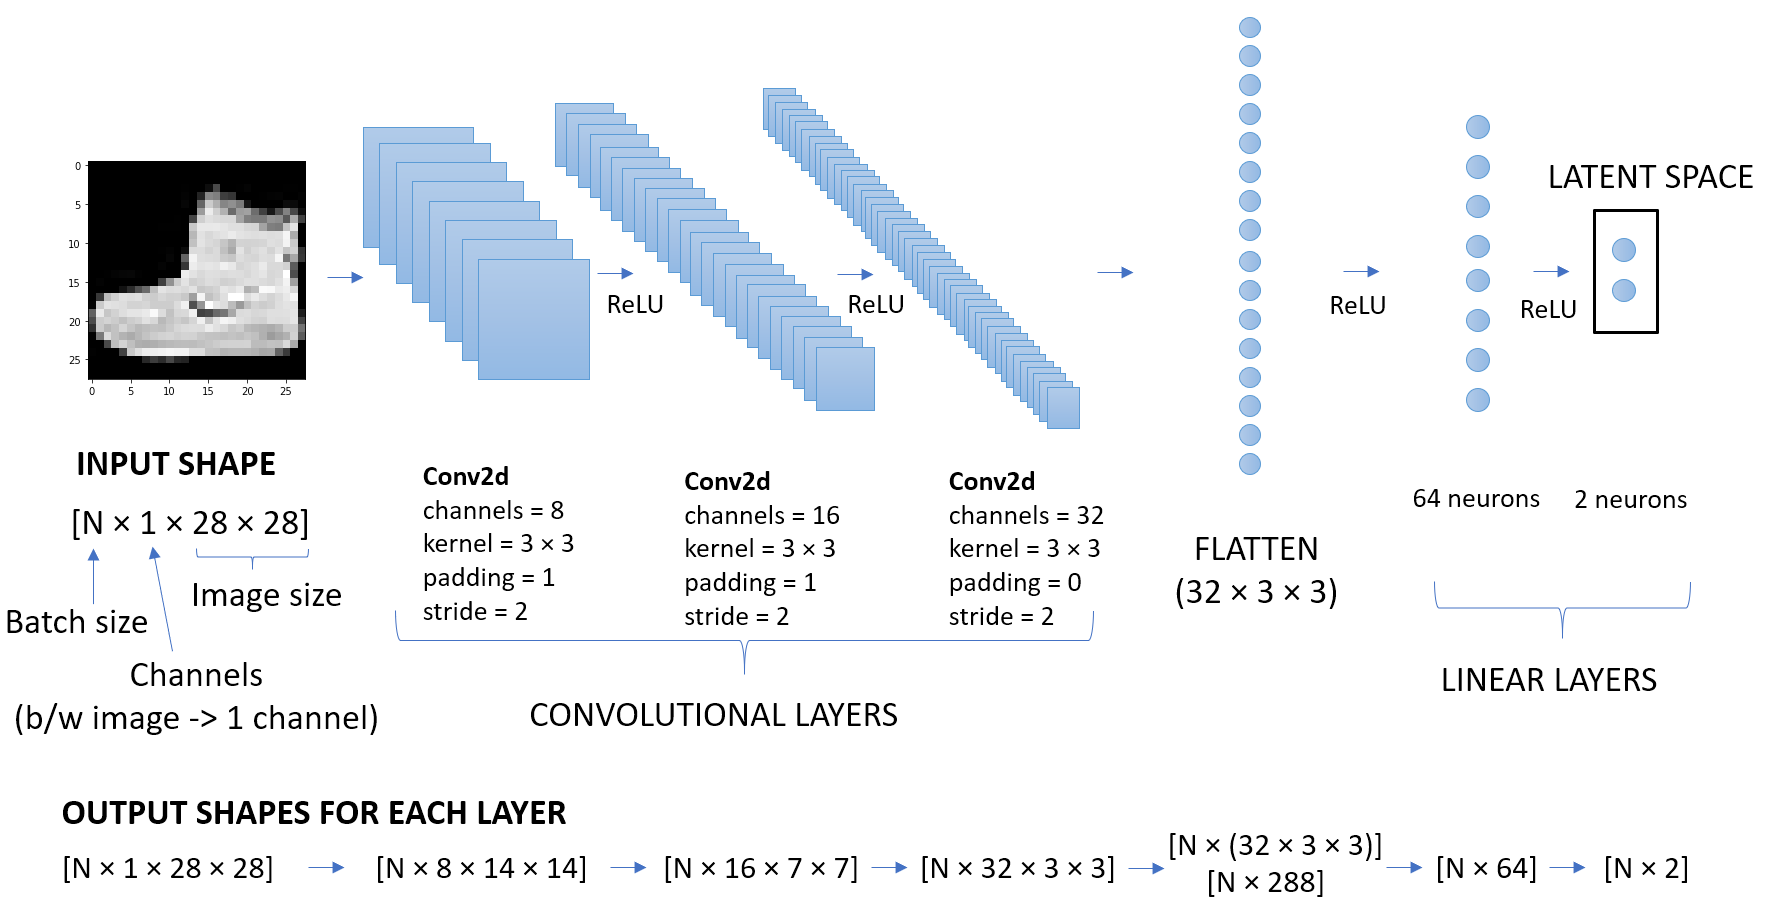

In [8]:
class ConvAutoEncoder(pl.LightningModule):

    def __init__(self, hp : dict = None):
        super().__init__()

        if hp is None:
            self.hyper_parameters = {
                'optimizer' : 'Adam',
                'encoded_space_dim' : 10,
                'learning_rate' : 1e-3,
                'dropout_rate' : 0
            }    
        else:
            self.hyper_parameters = hp

        self.save_hyperparameters() # Store hyper_parameters in checkpoints

        self.dropout_rate = self.hyper_parameters['dropout_rate']
        self.encoded_space_dim = self.hyper_parameters['encoded_space_dim']

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(self.dropout_rate),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(self.dropout_rate),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout(self.dropout_rate),
            nn.Flatten(start_dim=1),
            nn.Linear(32 * 3 * 3, 64),
            nn.ReLU(True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(64, self.encoded_space_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(64, 32 * 3 * 3),
            nn.ReLU(True),
            nn.Dropout(self.dropout_rate),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout(self.dropout_rate),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout2d(self.dropout_rate),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x : 'torch.tensor'):
        x = self.encoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx, loss_name='val_loss'):
        x, _ = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log(loss_name, loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = getattr(optim, self.hyper_parameters['optimizer']) \
                                  (self.parameters(), lr=self.hyper_parameters['learning_rate'])
        return optimizer

    def test_step(self, batch, batch_idx, loss_name='test_loss'):
        return self.validation_step(batch, batch_idx, loss_name=loss_name)

To ease the direct access to the lists/dictionaries of losses and other metrics logged during training and validation, we make used of a custom `MetricsCallback` `class`. Furthermore, in order to monitor the training process, we plot after every $n$ epoch an example of (random) reconstructed sample through a `GenerateCallback` `class`, adapted from [this tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html). An example of its functioning is given in the first training process of the next section.

Lastly, a series of 3 helper function is defined to better manage PyTorch model saving, loading and deleting.

In [9]:
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append({key: val.item() for (key, val) in trainer.callback_metrics.items()})
        
class GenerateCallback(Callback):

    def __init__(self, dataset, every_n_epochs=1):
        super().__init__()
        self.dataset = dataset
        self.every_n_epochs = every_n_epochs
        
        num = np.random.randint(0, len(dataset))
        self.sample_img, self.label_img = random.choice(self.dataset)
        self.sample_img = self.sample_img.unsqueeze(0)
    def on_train_epoch_end(self, trainer, pl_module):
        current_epoch = trainer.current_epoch
        if current_epoch % self.every_n_epochs == 0:
            
            # Reconstruct images
            pl_module.eval()
            with torch.no_grad():
                enc = pl_module.encoder(self.sample_img.to(pl_module.device))
                dec = pl_module.decoder(enc)
                
            sample_img = self.sample_img.squeeze().cpu().numpy()
            reconst_img = dec.squeeze().cpu().numpy()
            
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.imshow(sample_img, cmap='gist_gray')
            ax1.set_title(f'Orig: {mnist_labels[int(self.label_img)]} [{self.label_img}]')
            ax1.set_xticks([]); ax1.set_yticks([])
            
            ax2.imshow(reconst_img, cmap='gist_gray')
            ax2.set_title(f'Reco: epoch {current_epoch + 1} ({pl_module.encoded_space_dim} latents)')
            ax2.set_xticks([]); ax2.set_yticks([])
            
            plt.show()

In [10]:
model_folder = 'SavedModels/'

def save_model(name : str, trainer : 'pl.Trainer', metrics : 'MetricsCallback'):
    trainer.save_checkpoint(model_folder + name + '.ckpt')
    df = pd.DataFrame(metrics_callback.metrics)
    df.to_csv(model_folder + name + '.csv', index=False)

def load_model(name : str, module : 'pl.Module') -> Tuple['pl.Module', 'pd.DataFrame']:
    model = module.load_from_checkpoint(model_folder + name + '.ckpt')
    metrics = pd.read_csv(model_folder + name + '.csv')
    return model, metrics

def delete_model(name : str):
    os.remove(model_folder + name + '.ckpt', missing_ok=True)
    os.remove(model_folder + name + '.csv', missing_ok=True)

<a id='3'></a>
[Index](#index)
### 3. First training example and sample generation

Here we give a first example of training with some arbitrary learning hyperparameters (contained in the `hyper_parameters` dictionary). To avoid overfitting, we set the patience (i.e. the number of epochs after which training is stopped if the validation loss has not decreased) to $5$ and the maximum number of epochs to $100$. The latent space dimension is set to $2$ to allow for direct plotting of the representations as points in a plane. In the last plot of this section, the first 1000 samples are represented.

The `loss_reconstruction` function reconstructs the learning curves accumulated during the training and validation process, while the `plot_reconstructed_samples` function plots in a $(3\times 3)$ grid examples of (random) original and reconstructed images from the validation set for a given model. A `VAE` flag takes care of the variational autoencoder case explored later on.

Already for this first simple example, the model achieves a a good reconstruction: the network is able to distinguish between the defining characteristics of each garment and to form recognizable clusters for items belonging to the same class.<br>
It is interesting to observe the learning process of the network after each epoch in the plots below.

In [11]:
def loss_reconstruction(metrics, title):
    fig, ax = plt.subplots()

    xs = np.arange(len(metrics) - 1) + 1

    ax.plot(xs, metrics['train_loss'][1:], c='b', label='Train')
    ax.plot(xs, metrics['val_loss'][1:], c='r', label='Validation')

    ax.set_title(title)

    ax.set_ylabel('Reconstruction error (MSE)'); ax.set_xlabel('Epoch')
    ax.grid(True); ax.legend()
    plt.tight_layout()
    
def plot_reconstructed_samples(model, VAE=False):
    
    model.eval()
    model = model.to(device)

    n_rows, n_cols = 3, 3
    fig = plt.figure(figsize=(12, 8))

    for place in gridspec.GridSpec(n_rows, n_cols, figure=fig):
        grid = place.subgridspec(1, 2)

        ax1 = fig.add_subplot(grid[0])
        ax2 = fig.add_subplot(grid[1])

        x, y = random.choice(mnist.mnist_val)

        with torch.no_grad():
            if VAE:
                enc, _, _ = model(x.unsqueeze(0))
            else:
                enc = model.encoder(x.unsqueeze(0))
            rec = model.decoder(enc)

        ax1.imshow(x.cpu().numpy().reshape(28, 28), cmap='gist_gray')
        ax2.imshow(rec.cpu().numpy().reshape(28, 28), cmap='gist_gray')
        
        ax1.set_title(f'Orig: {mnist_labels[int(y)]} [{y}]')
        ax2.set_title('Reconstructed')
        ax1.axis('off'); ax2.axis('off')

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.tight_layout(w_pad=2, h_pad=3)
    plt.suptitle(f'Original and reconstructed samples ({model.encoded_space_dim} latents)', y=1.05)
    plt.show()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.5 K
1 | decoder | Sequential | 24.8 K
---------------------------------------
49.3 K    Trainable params
0         Non-trainable params
49.3 K    Total params
0.197     Total estimated model params size (MB)
Metric val_loss improved. New best score: 0.044


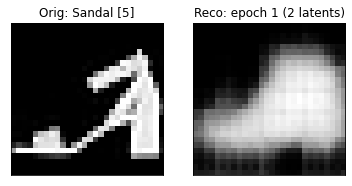

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.033


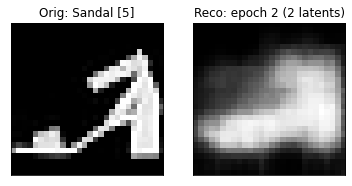

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.032


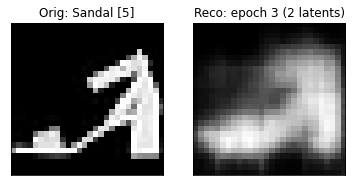

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.030


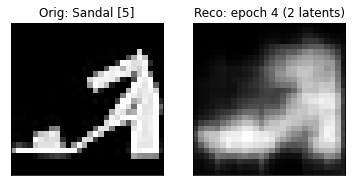

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.029


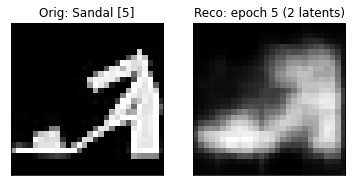

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


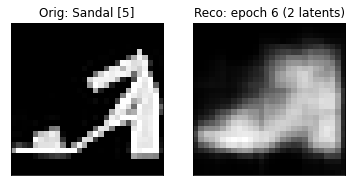

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


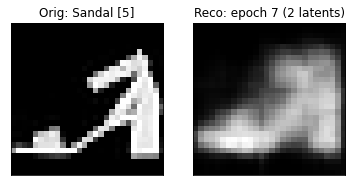

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


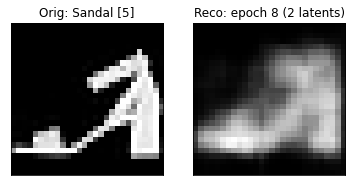

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


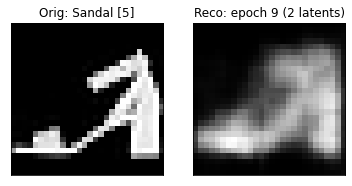

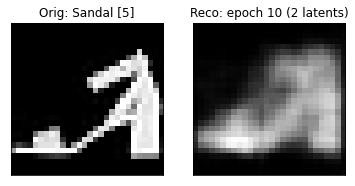

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


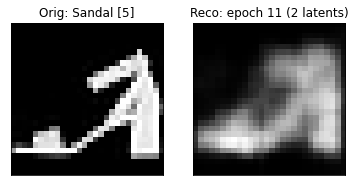

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.027


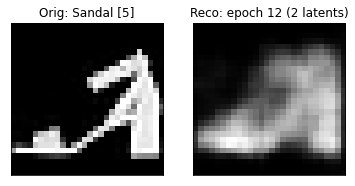

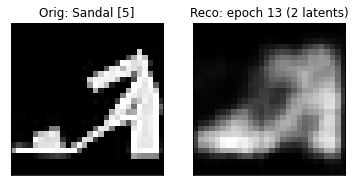

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.027


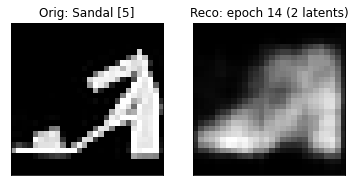

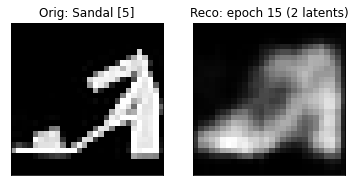

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.027


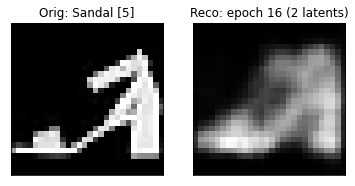

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.027


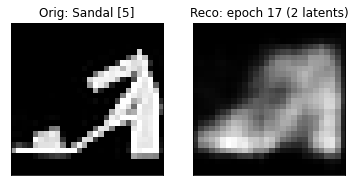

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.027


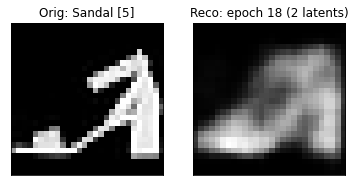

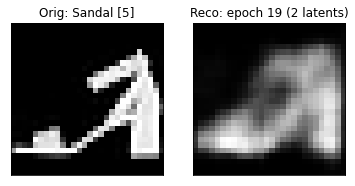

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.027


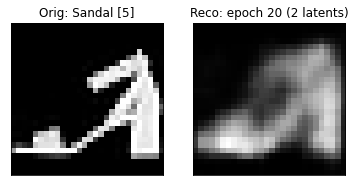

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.027


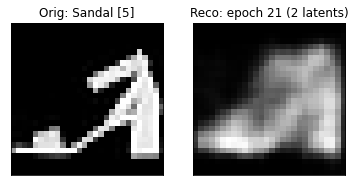

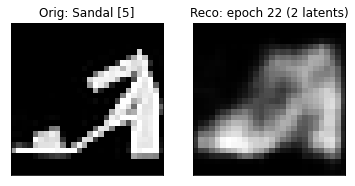

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.027


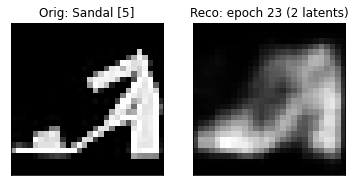

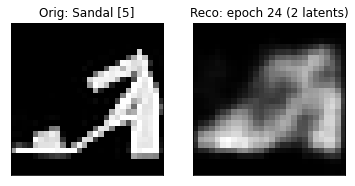

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


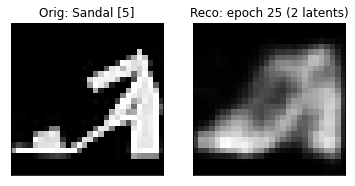

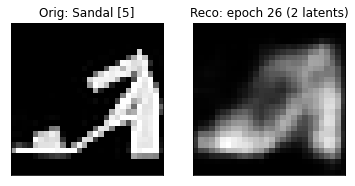

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


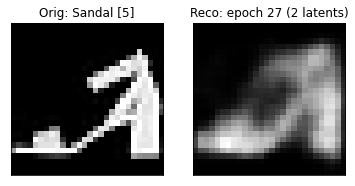

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


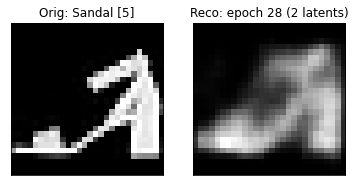

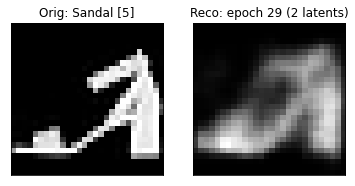

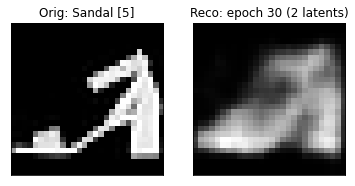

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


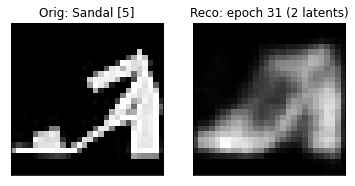

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


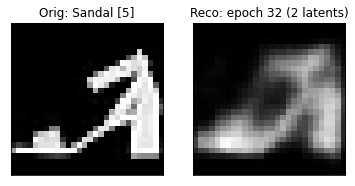

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


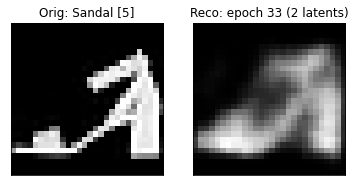

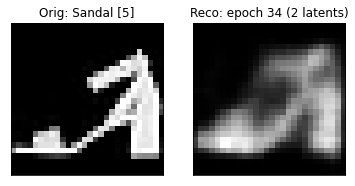

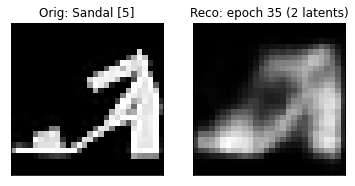

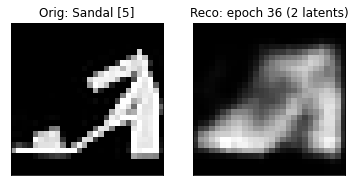

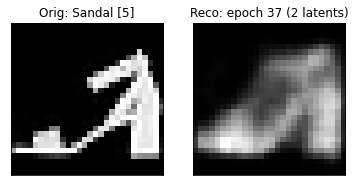

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


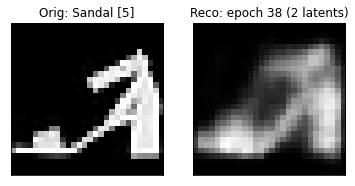

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


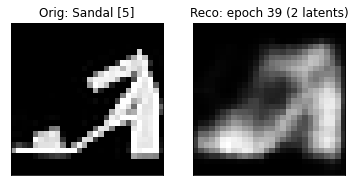

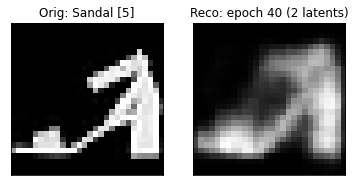

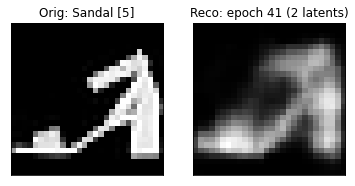

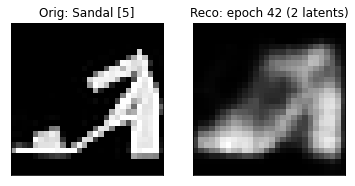

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


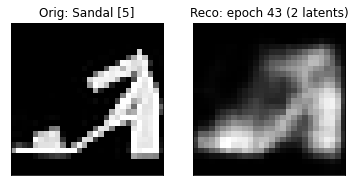

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


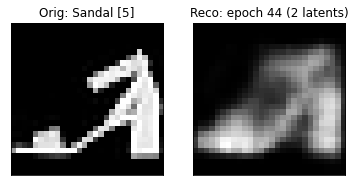

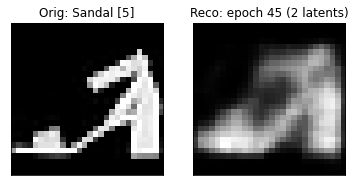

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


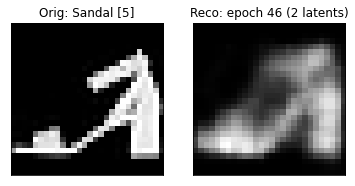

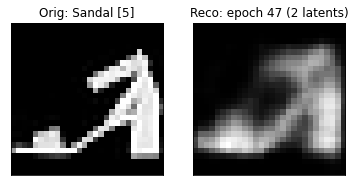

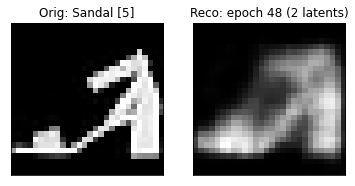

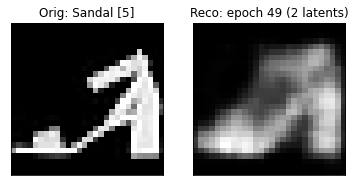

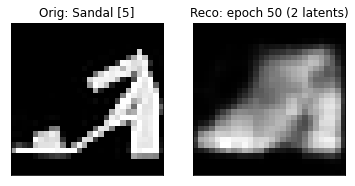

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


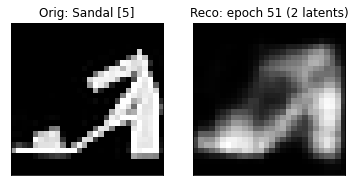

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


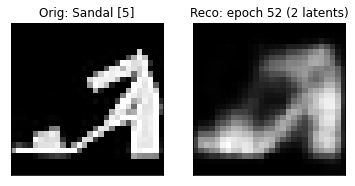

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


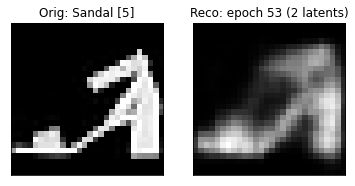

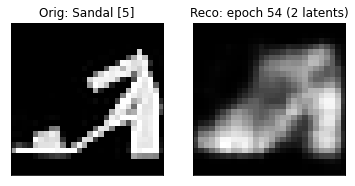

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


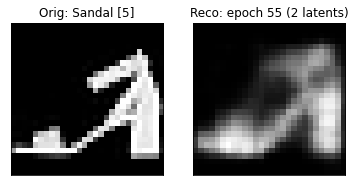

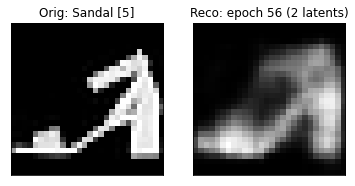

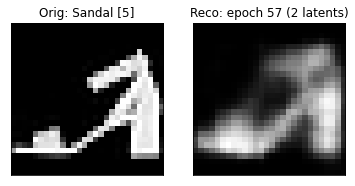

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.025


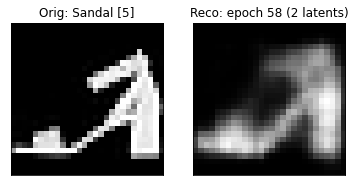

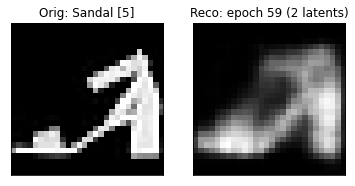

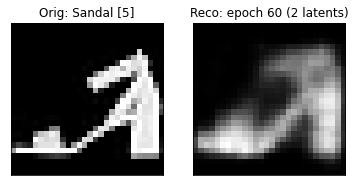

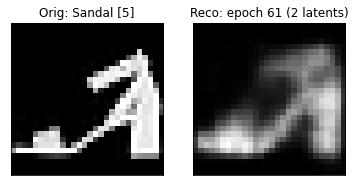

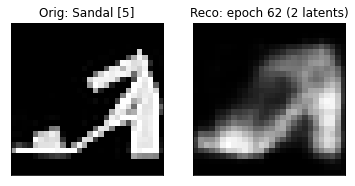

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.025. Signaling Trainer to stop.


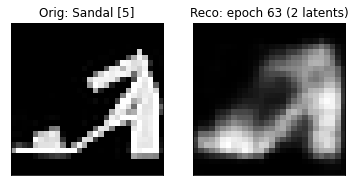

In [12]:
warnings.filterwarnings('ignore', category=DeprecationWarning) # Disable warnings
warnings.filterwarnings('ignore', '.*does not have many workers.*')

metrics_callback = MetricsCallback()
earlystopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=True)
reco_callback = GenerateCallback(dataset=mnist.mnist_val, every_n_epochs=1)

# Define training
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=100,
                     callbacks=[metrics_callback, earlystopping_callback, reco_callback],
                     enable_progress_bar=False)

# Define model
hyper_parameters = {
    'optimizer' : 'Adam',
    'encoded_space_dim' : 2,
    'learning_rate' : 1e-3,
    'dropout_rate' : .4
}
conv_autoencoder = ConvAutoEncoder(hp=hyper_parameters)

# Train
trainer.fit(conv_autoencoder, mnist)

# Save and load
save_model('conv_autoencoder_first', trainer, metrics_callback)
conv_autoencoder, metrics = load_model('conv_autoencoder_first', ConvAutoEncoder)

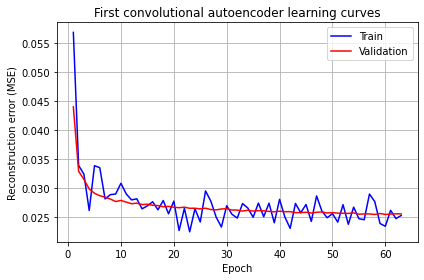

In [13]:
title = 'First convolutional autoencoder learning curves'
loss_reconstruction(metrics, title)

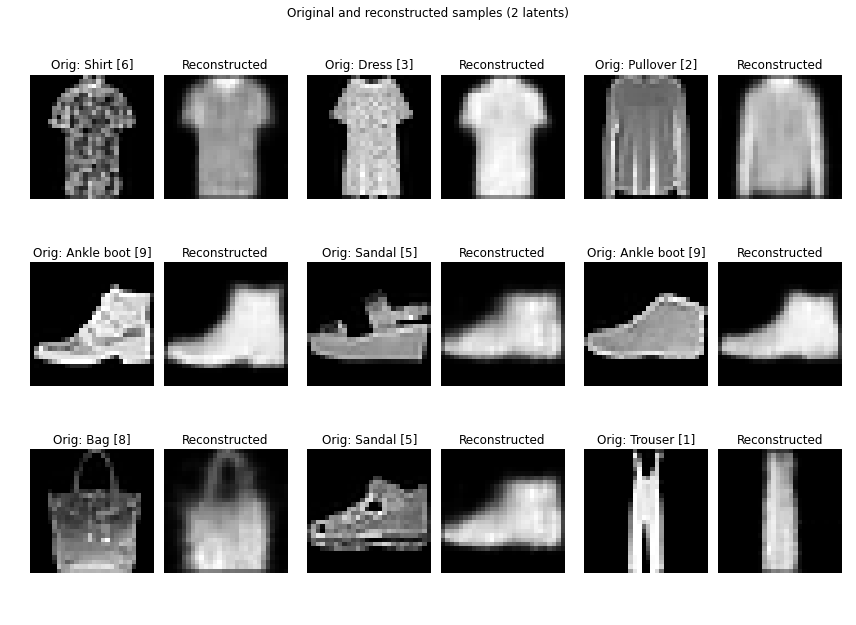

In [14]:
plot_reconstructed_samples(conv_autoencoder)

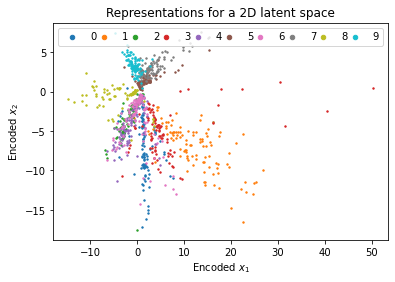

In [15]:
images, labels = mnist.mnist_val[:1000]
enc = conv_autoencoder.encoder(images).detach().cpu().numpy()

x, y = enc[:, 0], enc[:, 1]
images = images.squeeze(1).cpu().numpy()

data = pd.DataFrame({'x': x, 'y': y, 'label': labels.cpu()})
groups = data.groupby('label')

for name, group in groups:
    plt.scatter(group['x'], group['y'], marker='o', label=name, s=2)
    
plt.title('Representations for a 2D latent space')
plt.xlabel('Encoded $x_1$'); plt.ylabel('Encoded $x_2$')
lgnd = plt.legend(loc='upper right', mode='expand', ncol=len(np.unique(y)))
for handle in lgnd.legendHandles:
    handle.set_sizes([20])
plt.show()

The representation of the 2D latent space shows a peculiar distribution of the different labels that "irradiate" from the origin in $(0,0)$. The plot shows a well defined representation for almost all items, with the exception of the 0 (T-shirt/top) and 3 (Dress) category, that are scattered over a wider interval. This underlines once again the difficulty of the network in classifying these articles: pictorially, the more the encoded coordinates distribute along a line in this plane, the more "decided" is the network.

<a id='4'></a>
[Index](#index)
### 4. Hyperparameter optimization: Optuna

The search space for hyperparameters is defined in an objective function to allow optimization via Optuna. The optimizer, the encoded space dimension, the learning rate, dropout and batch size are studied, as reported in the following cell: $100$ experiments are run in different configurations.

An RDB backend is used to allow the saving and resuming of a study, as well as access to history of studies. In this case, a persistent study is created on a local environment with SQLite DB.

In [16]:
def objective(trial: optuna.trial.Trial) -> float:
    optimizer = trial.suggest_categorical('optimizer', ['SGD', 'Adam'])
    encoded_space_dim = trial.suggest_int('encoded_space_dim', 2, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    
    hyper_parameters = {
        'optimizer' : optimizer,
        'encoded_space_dim' : encoded_space_dim,
        'learning_rate' : learning_rate,
        'dropout_rate' : dropout_rate,
        'batch_size' : batch_size
    }

    mnist = FashionMNISTDataModule(batch_size=batch_size)
    model = ConvAutoEncoder(hp = hyper_parameters)

    trainer = pl.Trainer(
        logger = False,
        limit_val_batches=1.,
        checkpoint_callback=False,
        max_epochs=10,
        gpus=1 if torch.cuda.is_available() else None,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor='val_loss')]
    )
    
    trainer.fit(model, datamodule=mnist)

    return trainer.callback_metrics['val_loss'].item()

In [17]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=30, interval_steps=10)
study_name = 'conv_autoencoder'
study = optuna.create_study(study_name=study_name, storage='sqlite:///conv_autoencoder.db', 
                            direction='minimize', pruner=pruner, load_if_exists=True)

# study.optimize(objective, n_trials=100, timeout=None)

[I 2022-01-17 09:31:08,409] Using an existing study with name 'conv_autoencoder' instead of creating a new one.


The final values found by optimization are saved and used to train all subsequent models. Interestingly, the latent space dimension is not the highest allowed: this suggests that few dimensions suffice to capture all the data variability.

Below we report some noteworthy plots obtained during the optimization process.

In [18]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial: ')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial: 
  Value: 0.02430880442261696
  Params: 
    batch_size: 256
    dropout_rate: 0.21278490933466043
    encoded_space_dim: 9
    learning_rate: 0.002576788114759138
    optimizer: Adam


In [19]:
from optuna.visualization import plot_optimization_history, plot_intermediate_values, plot_parallel_coordinate

plot_optimization_history(study, target_name='Validation loss')

In [20]:
plot_intermediate_values(study)

In [21]:
plot_parallel_coordinate(study,  target_name='Validation loss')

<a id='5'></a>
[Index](#index)
### 5. Training with the best found model

The autoencoder with the best learning hyperparameters is trained for a maximum of $100$ epochs. The final $\mathrm{MSE}$ loss reached on the test dataset is of $\approx 0.013$; some examples of reconstruction are given below and deemed satisfactory: the network is able to capture more details, although some minor features are still not well represented.

In [22]:
best_hyperparameters = trial.params

metrics_callback = MetricsCallback()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=True)
reco_callback = GenerateCallback(dataset=mnist.mnist_val, every_n_epochs=1)
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath=model_folder + 'conv_model_best',
                                      filename='conv_autoencoder_{epoch:02d}_{val_loss:.2f}', save_top_k=5, mode='min')

# Define training
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=100,
                     callbacks=[checkpoint_callback, metrics_callback, reco_callback, earlystopping_callback],
                     enable_progress_bar=False)

# Define data
mnist = FashionMNISTDataModule(batch_size=best_hyperparameters['batch_size'])

# Define model
conv_autoencoder = ConvAutoEncoder(hp=best_hyperparameters)

# Train
# trainer.fit(conv_autoencoder, mnist)

# Save and load
# save_model('conv_autoencoder_best', trainer, metrics_callback)
conv_autoencoder, metrics = load_model('conv_autoencoder_best', ConvAutoEncoder)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


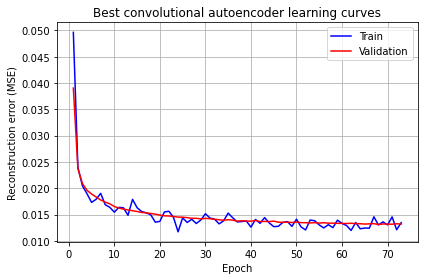

In [23]:
title = 'Best convolutional autoencoder learning curves'
loss_reconstruction(metrics, title)

In [24]:
trainer.validate(model=conv_autoencoder, datamodule=mnist)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 0.013091144151985645}
--------------------------------------------------------------------------------


[{'val_loss': 0.013091144151985645}]

In [25]:
trainer.test(model=conv_autoencoder, datamodule=mnist)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.01324856374412775}
--------------------------------------------------------------------------------


[{'test_loss': 0.01324856374412775}]

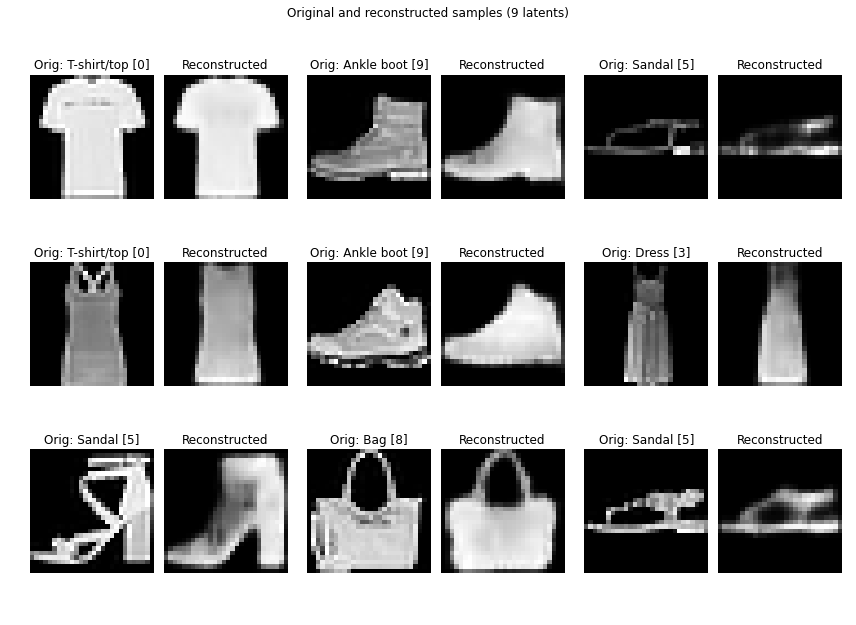

In [26]:
plot_reconstructed_samples(conv_autoencoder)

We generate here new samples starting from latent codes: 20 examples are given starting from 2D vectors with elements randomly uniformly distributed in the interval $[-10,10]$. We can see that e.g. for item #16 we can recognize a sandal, while for #7 the shape of a pullover can be glimpsed.

Latent code: [ 3.14  8.78  0.06  4.23 -9.92 -0.04  0.17 -3.76  8.05]


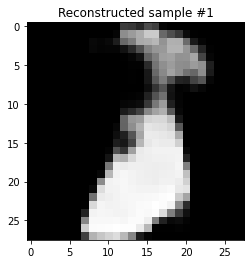

Latent code: [-6.59  4.92  8.4  -7.5  -8.84 -1.22 -2.19  1.65  6.04]


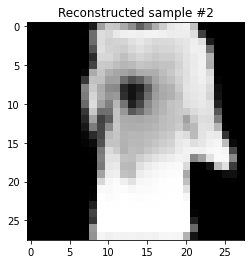

Latent code: [ 7.81  5.91 -3.2  -5.18  0.81  3.68 -3.06 -0.43 -3.2 ]


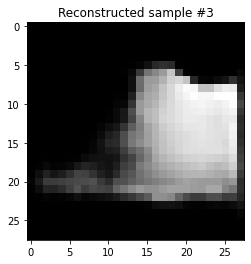

Latent code: [ 2.81  5.88 -3.02  3.43 -0.89  3.21 -3.93 -6.51  8.93]


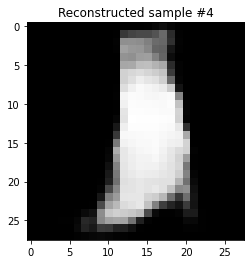

Latent code: [-5.29  4.39 -7.74 -6.1  -1.47  8.93  3.2  -7.25  6.15]


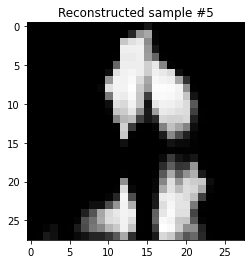

Latent code: [ 9.81  8.96 -0.46 -2.51 -6.59  1.03 -4.09 -0.76 -6.51]


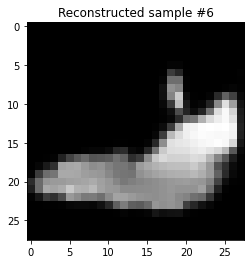

Latent code: [-2.27 -6.24  2.57 -6.08  5.66 -0.53 -5.24 -7.39  0.12]


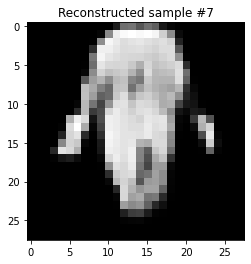

Latent code: [ 3.11 -8.82 -2.67 -9.81 -3.    8.66 -4.71  3.74  9.18]


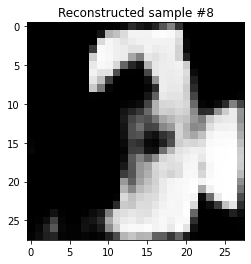

Latent code: [ 4.85 -5.45  4.12  5.16  0.89  1.01 -9.09  7.86  3.49]


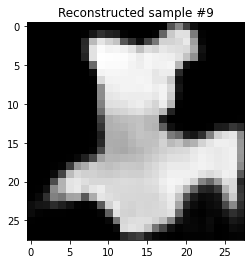

Latent code: [-4.34 -0.96  9.79  3.54 -9.02  6.85 -9.9   3.64 -6.92]


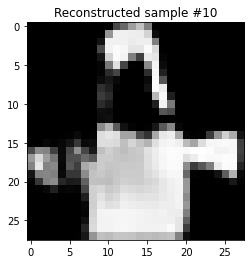

Latent code: [-2.72  2.58  8.45 -7.76 -9.49  5.96 -3.1   0.15 -5.86]


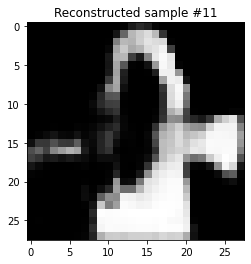

Latent code: [ 1.44 -0.48  8.48  3.85  9.09 -7.77  0.2  -6.3  -6.69]


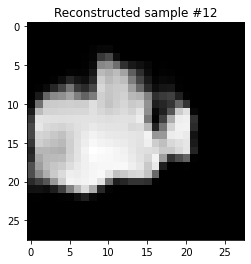

Latent code: [ 9.3  -4.86 -8.43  6.81  8.07  4.89  2.93 -0.96 -1.71]


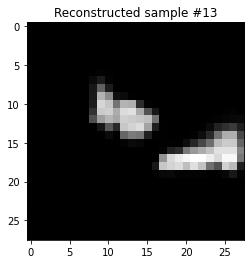

Latent code: [-4.44  5.1  -2.65 -6.58  5.72 -4.71 -2.92 -3.16 -6.03]


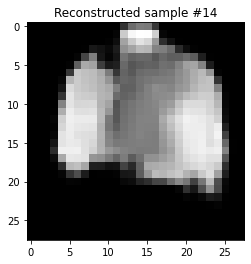

Latent code: [ 0.26 -3.69 -2.57 -1.68 -3.24  9.67 -7.45 -5.35  5.86]


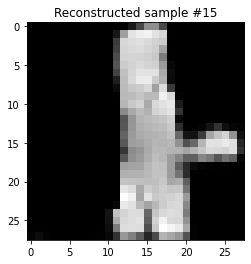

Latent code: [ 2.14  6.88 -2.6   8.81 -3.37 -9.59 -6.05  7.02  2.72]


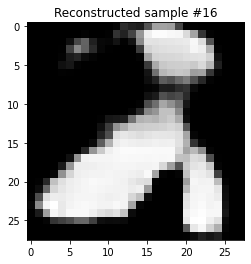

Latent code: [ 8.3   3.08  1.35  8.12  3.72 -7.29 -6.76 -6.97  0.69]


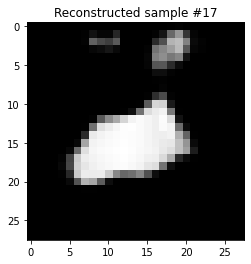

Latent code: [-8.41  6.04 -7.57 -1.89 -7.66  3.93  6.55 -3.31  4.21]


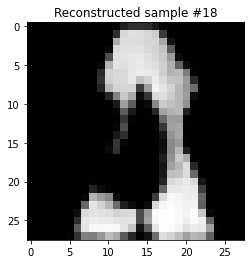

Latent code: [ 9.07 -5.92 -7.18 -4.24 -6.34 -3.96 -2.24  9.59 -6.99]


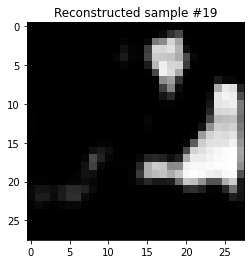

Latent code: [ 6.86 -0.99  9.65 -1.42  3.05 -8.96  8.88  6.49  7.8 ]


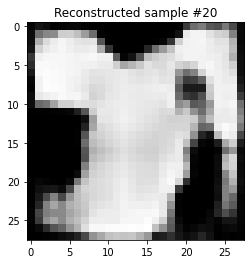

In [27]:
encoded_space_dim = conv_autoencoder.encoded_space_dim
count = 1
for _ in range(20):
    latent_values = [random.uniform(-10, 10) for _ in range(encoded_space_dim)]
    print(f'Latent code: {np.round(latent_values, 2)}')

    custom_values = torch.tensor(latent_values)
    custom_values = custom_values.float().unsqueeze(0).to(device)

    conv_autoencoder.eval()
    with torch.no_grad():
        generated_img = conv_autoencoder.decoder(custom_values)

    generated_img = generated_img.squeeze().cpu().numpy()
    plt.imshow(generated_img, cmap='gist_gray')

    plt.title(f'Reconstructed sample #{count}')
    count += 1
    plt.show()

<a id='6'></a>
[Index](#index)
### 6. Latent space visualization

In this section we show the PCA/t-SNE projection of the latent representations of the images. We can clearly see that even if no label is provided, the model is able to form distinct clusters of the same item. As a first step, we get the encoded representation of the test samples. The algorithms are taken from the `sklearn` library.

In [28]:
warnings.simplefilter('ignore', category=FutureWarning)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

conv_autoencoder.eval()
enc_samples, enc_labels = [], []
for (x, y) in mnist.mnist_val:
    img = x.unsqueeze(0).to(device)
    with torch.no_grad():
        encoded_img  = conv_autoencoder.encoder(img)
    # Append to list
    enc_labels += [y.cpu().numpy()]
    enc_samples += [encoded_img.flatten().cpu().numpy()]
    
enc_samples = np.vstack(enc_samples)
enc_labels = np.hstack(enc_labels)

Explained variation per principal component: [0.43437663 0.22840324]


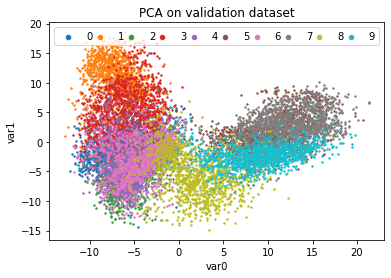

In [29]:
pca = PCA(n_components=2)
projected_features = pca.fit_transform(enc_samples)

print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

data = pd.DataFrame({'var0': projected_features[:, 0], 'var1': projected_features[:, 1], 'label': enc_labels})
groups = data.groupby('label')

for name, group in groups:
    plt.scatter(group['var0'], group['var1'], marker='o', label=name, s=2)

plt.title('PCA on validation dataset')
plt.xlabel('var0'); plt.ylabel('var1')
lgnd = plt.legend(loc='upper right', mode='expand', ncol=len(np.unique(enc_labels)))
for handle in lgnd.legendHandles:
    handle.set_sizes([20])
plt.show()

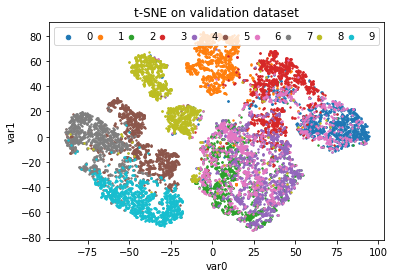

In [30]:
tsne_projected = TSNE(n_components=2).fit_transform(enc_samples)

data = pd.DataFrame({'var0': tsne_projected[:, 0], 'var1': tsne_projected[:, 1], 'label': enc_labels})
groups = data.groupby('label')

for name, group in groups:
    plt.scatter(group['var0'], group['var1'], marker='o', label=name, s=2)

plt.title('t-SNE on validation dataset')
plt.xlabel('var0'); plt.ylabel('var1')
lgnd = plt.legend(loc='upper right', mode='expand', ncol=len(np.unique(enc_labels)))
for handle in lgnd.legendHandles:
    handle.set_sizes([20])
plt.show()

We also compare the average distance between representations of the same articles, and representations of different articles, finally averaging over the pairwise distance. The ratio of the two gives an estimate of the "goodness" of the classifier: the smaller, the neater the separation between clusters.

In [31]:
from scipy.spatial.distance import cdist, pdist

out_dist, in_dist = [], []

for num in range(len(mnist_labels)):
    c_dist = cdist(enc_samples[enc_labels==num], enc_samples[enc_labels!=num])
    out_dist.append(c_dist.mean())
    p_dist = pdist(enc_samples[enc_labels==num])
    in_dist.append(p_dist.mean())
    
avg_out = np.mean(out_dist)
avg_in = np.mean(in_dist)

print('Average distance:')
print(f'  Outer: {avg_out:.3f}')
print(f'  Inner: {avg_in:.3f}')
print(f'  Ratio: {avg_in/avg_out:.3f}')

Average distance:
  Outer: 16.759
  Inner: 9.171
  Ratio: 0.547


<a id='7'></a>
[Index](#index)
### 7. Fine-tuning to a supervised task

A pre-trained autoencoder can be fine-tuned to a supervised task such as classification. This allows for significant speed-up of the training process, while in principle maintaining the same performances of a fully-trained CNN.

To test this, in this section we attach the encoder block of the convolutional autoencoder of [Sec. 5](#5) to two fully-connected layers of 64 and 10 neurons each, separated by a ReLU activation. Only the parameters of the latter segment are trained while keeping the other "frozen" to their previously learned values.<br>
The final network is trained for a maximum of 50 epochs with early stopping; training requires a couple of minutes to complete. The final accuracy reached is of $\approx 0.758$ on the test set, a satisfactory result when one considers the number of trainable parameters, that is just under $6$k. Still, an extensive search for hyperparameters should be carried out.

The accuracy remains distant from the one obtained in the previous homework (around $\approx 90\%$), showing how exploiting a pre-trained network can be just enough to quickly reach some results. To get the best performance however, a fully-trained network proves to be essential.

In [32]:
class SupervisedFineTuner(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.autoencoder = ConvAutoEncoder.load_from_checkpoint(model_folder + 'conv_autoencoder_best.ckpt')
        self.autoencoder.freeze()
        self.encoder = self.autoencoder.encoder
        self.encoded_space_dim = self.autoencoder.encoded_space_dim

        self.fine_tune = nn.Sequential(
            nn.Linear(self.encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 10),
            nn.LogSoftmax(),
)

        # Accuracy metric
        self.metric = torchmetrics.Accuracy()
    
    def forward(self, x : 'torch.tensor'):
        x = self.encoder(x)
        x = self.fine_tune(x)
        return x
    
    def training_step(self, batch, batch_idx, log_name='train'):
        x, y = batch
        z = self.forward(x)
        
        loss = F.cross_entropy(z, y)
        acc  = self.metric(z, y)

        self.log(log_name + '_loss', loss)
        self.log(log_name + '_acc', acc, prog_bar=True)

        return loss
    
    def validation_step(self, batch, batch_idx, log_name='val'):
        return self.training_step(batch, batch_idx, log_name=log_name)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=best_hyperparameters['learning_rate'])
        return optimizer

    def test_step(self, batch, batch_idx, log_name='test'):
        return self.validation_step(batch, batch_idx, log_name=log_name)

In [33]:
metrics_callback = MetricsCallback()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True)

# Define training
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=50,
                     callbacks=[metrics_callback, early_stopping_callback],
                     enable_progress_bar=False)

# Define model
supervised_fine_tuner = SupervisedFineTuner()

# Train
# trainer.fit(supervised_fine_tuner, mnist)

# Save and load
# save_model('conv_autoencoder_supervised', trainer, metrics_callback)
conv_autoencoder_ft, metrics = load_model('conv_autoencoder_supervised', SupervisedFineTuner)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [34]:
trainer.test(model=conv_autoencoder_ft, dataloaders=mnist)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/spiccinelli/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7584999799728394, 'test_loss': 0.7244255542755127}
--------------------------------------------------------------------------------


[{'test_loss': 0.7244255542755127, 'test_acc': 0.7584999799728394}]

In [35]:
# title = 'Supervised convolutional autoencoder learning curves'
# loss_reconstruction(metrics, title)

<a id='8'></a>
[Index](#index)
### 8. Variational autoencoder

A variational autoencoder (VAE) is a probabilistic version of the autoencoder. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a (multivariate) Gaussian. The form of the probability distribution is a degree of freedom of the algorithm, and through regularization it can be forced to be the simplest possible. This approach produces a continuous latent space that is useful for image generation. The resulting model is more interpretable and robust to noise.

The encoder architecture of [Sec. 5](#5) is modified to output the parameters of a multivariate Gaussian (MVG) $\mathcal{N}(\vec{\mu},\Sigma)$ with (assumed) diagonal covariance matrix $\Sigma=\mathrm{diag}(\sigma^2_1,\dots,\sigma^2_d)\equiv\vec{\sigma}^2$. This last choice is made to save computational resources, generating only a $d$-dimensional vector instead of a $d\times d$ matrix.<br>
The convolutional segment is kept unchanged but its output is sent to two copies of the fully connected block. The first (`self.mu` in the class definition below) computes the mean vector, while the second (`self.logvar`) returns the logarithm of the variances.<br>
The loss function can be minimized such that the resulting distribution is as close as possible to a MVG, using as measure the error given by the Kullback-Leibler ($\mathrm{KL}$) divergence. Being $x$ the original sample and $\hat{x}$ the reconstructed one,

\begin{align*}
\mathcal{L}(x,\hat{x})&=\mathrm{BCE}(x,\hat{x})+\mathrm{KL}\left[\mathcal{N}(\vec{\mu},\vec{\sigma}^2),\mathcal{N}(\vec{0},\vec{1})\right]\\
&=\mathrm{BCE}(x,\hat{x})-\frac{1}{2}\sum^{d}_{i=1}(1+\log\sigma^2_i-\mu^2_i-\sigma^2_i)\quad,
\end{align*}

where the $\mathrm{KL}$ divergence and the $\mathrm{BCE}$ represent the regularization and the reconstruction error term respectively, the latter in the form of the binary cross entropy (as explained in the Appendix B of [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma and Welling).

If we denote with $\vec{\mu}$ and $\vec{\sigma}^2$ the vector of the means and variances, a sample $\vec{s}$ can be reconstructed as

\begin{align*}
\vec{s}&\simeq\vec{\mu} + \vec{\zeta}\cdot\exp\left(\frac{1}{2}\cdot \log\vec{\sigma}^2\right)=\vec{\mu} + \vec{\zeta}\cdot\vec{\sigma}^2\\
\vec{\zeta}&\sim\mathcal{N}(\vec{0},\vec{1})\quad,
\end{align*}

where all operation (including exponentiation, thanks to the fact that $\Sigma$ is diagonal) are intended element-wise. This trick is useful to mimic the discrete sampling process $\vec{s}\sim\mathcal{N}(\vec{\mu},\vec{\sigma}^2)$. However, using the above equations to reconstruct a sample $s$ guarantees differentiability (which a discrete sampling process does not) and thus allows for backpropagation with respect to the network's parameters.

Some code snippets used in the following analysis are adapted from [this GitHub repository](https://gist.github.com/koshian2/64e92842bec58749826637e3860f11fa).

In [36]:
class VAE(pl.LightningModule):

    def __init__(self, encoded_space_dim):
        super().__init__()
        self.save_hyperparameters()
        self.encoded_space_dim = encoded_space_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Flatten(start_dim=1)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 32 * 3 * 3),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        # Mean MVG
        self.mu = nn.Sequential(
            nn.Linear(32 * 3 * 3, 64),
            nn.ReLU(True),
            nn.Linear(64, self.encoded_space_dim)
        )
        # (Log-) variance MVG
        self.logvar = nn.Sequential(
            nn.Linear(32 * 3 * 3, 64),
            nn.ReLU(True),
            nn.Linear(64, self.encoded_space_dim)
        )
        
    def loss_function(self, x_hat, x, mu, logvar):
        BCE = F.binary_cross_entropy(x_hat, x, size_average=False)        
        KLD = -0.5 * torch.sum(1. + logvar - mu**2 - torch.exp(logvar))
        return BCE + KLD
    
    def forward(self, x):
        enc = self.encoder(x)
        mu = self.mu(enc)
        logvar = self.logvar(enc)
        # Sampling
        sample = mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)
        return sample, mu, logvar

    def training_step(self, batch, batch_idx, log_name='train'):
        x, _ = batch
        sample, mu, logvar = self.forward(x)  
        x_hat = self.decoder(sample)
        loss = self.loss_function(x_hat, x, mu, logvar)
        self.log(log_name + '_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx, log_name='val'):
        return self.training_step(batch, batch_idx, log_name=log_name)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def test_step(self, batch, batch_idx, log_name='test'):
        return self.training_step(batch, batch_idx, log_name=log_name)

We train the network for a maximum of 100 epochs, with the encoded dimension found during hyperparameter optimization in [Sec. 4](#4). An example of reconstructed samples is given below.

VAE cures the instability of the latent space of classical autoencoders in that they are more robust, meaning that small changes in the input are mapped to small changes in the latent space.<br>
Moreover, one can move continuously on the learned data manifold, visualizing a transition from one item to another along the line that links the two representations. We show this peculiar behaviour in the plots below.

Finally, we visualize the latent representation via PCA and t-SNE and generate new samples starting from uniformly random vectors of their latent space representations.

In [37]:
metrics_callback = MetricsCallback()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=True)

# Define training
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=100,
                     callbacks=[metrics_callback, early_stopping_callback],
                     enable_progress_bar=False)

# Define model
encoded_space_dim = conv_autoencoder.encoded_space_dim
variational_autoencoder = VAE(encoded_space_dim=encoded_space_dim)

# Train
trainer.fit(variational_autoencoder, mnist) 

# Save and load
save_model('vae_autoencoder', trainer, metrics_callback)
vae, metrics = load_model('vae_autoencoder', VAE)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 5.9 K 
1 | decoder | Sequential | 25.2 K
2 | mu      | Sequential | 19.1 K
3 | logvar  | Sequential | 19.1 K
---------------------------------------
69.3 K    Trainable params
0         Non-trainable params
69.3 K    Total params
0.277     Total estimated model params size (MB)
/home/spiccinelli/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.

Metric val_loss improved. New best score: 79396.562
Metric val_loss improved by 9362.680 >= min_delta = 0.0. New best score: 70033.883
Metric val_loss improved by 2482.828 >= min_delta = 0.0. New best score: 67551.055
Metric val_loss improved by 1005.984 >= min_delta = 0.0.

In [38]:
trainer.test(vae, mnist)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 62830.23828125}
--------------------------------------------------------------------------------


[{'test_loss': 62830.23828125}]

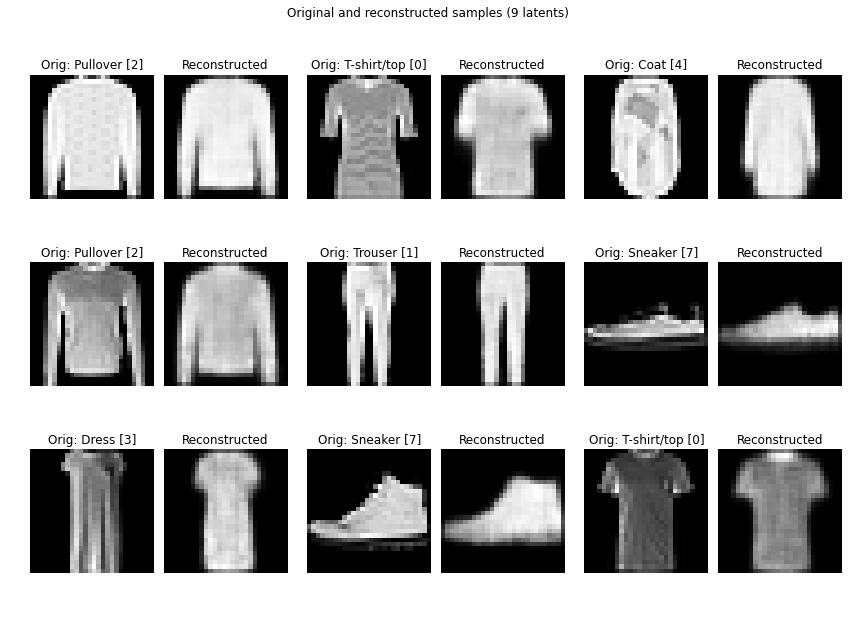

In [39]:
plot_reconstructed_samples(vae, VAE=True)

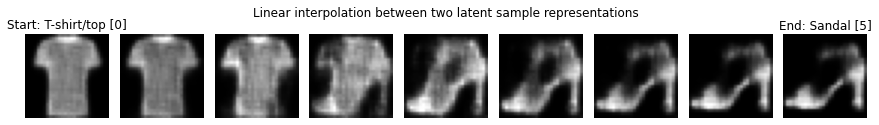

In [40]:
vae.eval()
vae = vae.to(device)

start, y1 = mnist.mnist_val[4]
end, y2 = mnist.mnist_val[2]

with torch.no_grad():
    start = vae.encoder(start.unsqueeze(0))
    end = vae.encoder(end.unsqueeze(0))
    
    start_img = vae.mu(start).cpu().numpy().flatten()
    end_img = vae.mu(end).cpu().numpy().flatten()
    
steps = 9
line = np.linspace(0, 1, steps)
states = np.array([start_img + val * (end_img - start_img) for val in line])
states = torch.tensor(states).to(device)

fig, axs = plt.subplots(1, steps, figsize=(12,8))

for i, (ax, state) in enumerate(zip(axs.ravel(), states)):
    with torch.no_grad():
        img = vae.decoder(state.unsqueeze(0))

    if i == 0: ax.set_title(f'Start: {mnist_labels[int(y1)]} [{y1}]')
    if i == steps-1: ax.set_title(f'End: {mnist_labels[int(y2)]} [{y2}]')

    ax.imshow(img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax.axis('off')
    
plt.suptitle('Linear interpolation between two latent sample representations', y=0.6)

plt.tight_layout()    

In [41]:
vae.eval()
enc_samples, enc_labels = [], []
for (x, y) in mnist.mnist_val:
    img = x.unsqueeze(0).to(device)
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    enc_labels += [y.cpu().numpy()]
    enc_samples += [encoded_img.flatten().cpu().numpy()]
    
enc_samples = np.vstack(enc_samples)
enc_labels = np.hstack(enc_labels)

Explained variation per principal component: [0.34367135 0.26782542]


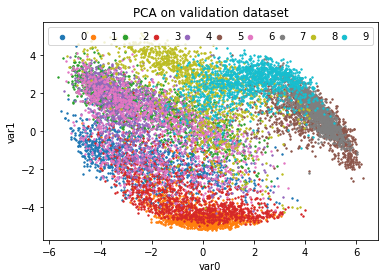

In [42]:
pca = PCA(n_components=2)
projected_features = pca.fit_transform(enc_samples)

print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

data = pd.DataFrame({'var0': projected_features[:, 0], 'var1': projected_features[:, 1], 'label': enc_labels})

groups = data.groupby('label')

for name, group in groups:

    plt.scatter(group['var0'], group['var1'], marker='o', label=name, s=2)

plt.title('PCA on validation dataset')
plt.xlabel('var0'); plt.ylabel('var1')
lgnd = plt.legend(loc='upper right', mode='expand', ncol=len(np.unique(enc_labels)))
for handle in lgnd.legendHandles:
    handle.set_sizes([20])
plt.show()

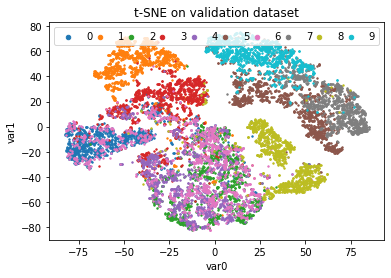

In [43]:
tsne_projected = TSNE(n_components=2).fit_transform(enc_samples)

data = pd.DataFrame({'var0': tsne_projected[:, 0], 'var1': tsne_projected[:, 1], 'label': enc_labels})

groups = data.groupby('label')

for name, group in groups:

    plt.scatter(group['var0'], group['var1'], marker='o', label=name, s=2)

plt.title('t-SNE on validation dataset')
plt.xlabel('var0'); plt.ylabel('var1')
lgnd = plt.legend(loc='upper right', mode='expand', ncol=len(np.unique(enc_labels)))
for handle in lgnd.legendHandles:
    handle.set_sizes([20])
plt.show()

In [44]:
out_dist, in_dist = [], []

for num in range(len(mnist_labels)):
    c_dist = cdist(enc_samples[enc_labels==num], enc_samples[enc_labels!=num])
    out_dist.append(c_dist.mean())
    p_dist = pdist(enc_samples[enc_labels==num])
    in_dist.append(p_dist.mean())
    
avg_out = np.mean(out_dist)
avg_in = np.mean(in_dist)

print('Average distance:')
print(f'  Outer: {avg_out:.3f}')
print(f'  Inner: {avg_in:.3f}')
print(f'  Ratio: {avg_in/avg_out:.3f}')

Average distance:
  Outer: 6.921
  Inner: 4.366
  Ratio: 0.631


Latent code: [-2.4  -9.56  1.37  8.17 -9.14  0.69 -8.3  -3.55  5.23]


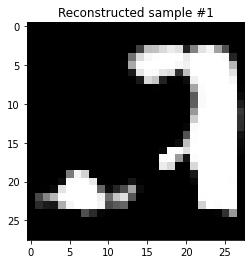

Latent code: [ 2.91  2.64 -9.59  9.97  8.88  3.22 -5.95 -9.06  5.14]


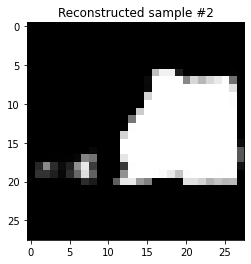

Latent code: [ 2.07 -3.28  1.36  0.   -1.14  8.81  7.18  2.02  9.35]


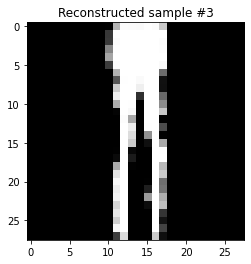

Latent code: [-9.95  6.01 -8.33  7.51 -0.85 -7.23  5.69 -8.13  4.39]


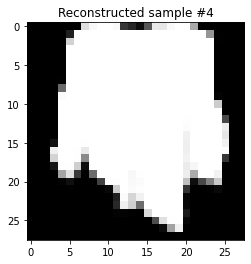

Latent code: [-6.64 -5.   -5.5  -9.78  5.2  -0.4  -7.24  8.47 -2.04]


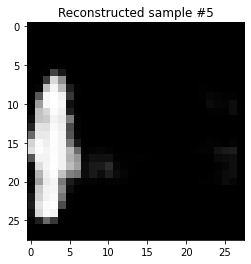

Latent code: [ 2.82  1.55 -1.82 -4.38  7.7  -2.41 -2.78  3.64 -1.86]


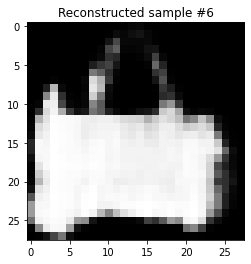

Latent code: [-4.95 -3.83 -9.03  2.19  9.61  4.12  5.63 -3.6   2.98]


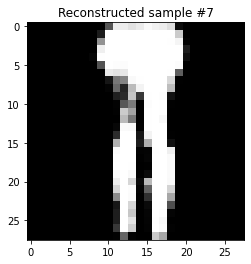

Latent code: [-4.94 -0.44  5.08  6.82 -8.6   1.71  4.15 -7.15  6.62]


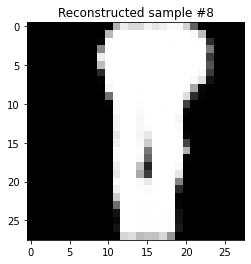

Latent code: [-6.53 -9.73  7.01 -0.12 -6.45  8.91  5.97  9.85 -2.89]


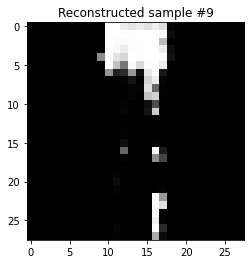

Latent code: [-7.86 -2.25  5.41  8.51 -6.19 -8.8   5.6  -7.48  6.46]


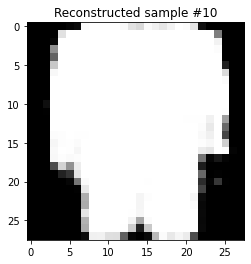

Latent code: [ 1.37  4.08  5.51 -1.85  2.    1.36  4.38  5.33  2.33]


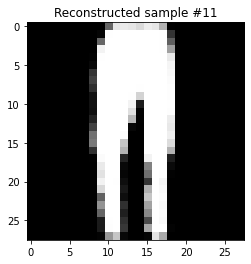

Latent code: [ 7.44  7.53 -5.63  3.53  8.79  4.5   9.82  4.85 -2.61]


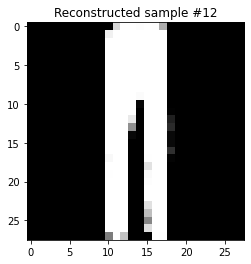

Latent code: [ 9.43  3.45 -9.85 -7.51  7.5   7.59  7.25  3.54  4.36]


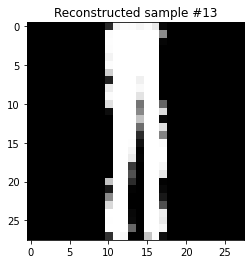

Latent code: [ 4.84 -4.78  2.6   6.99  6.72  9.89  7.28  7.91 -5.11]


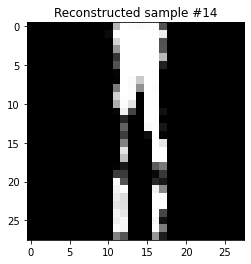

Latent code: [ 6.17  8.16  3.9   7.04 -4.66  3.15 -2.57 -3.91 -1.08]


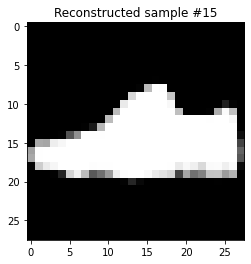

Latent code: [ 2.32 -6.9  -5.64 -1.28 -7.08  9.94 -8.5   6.8  -0.82]


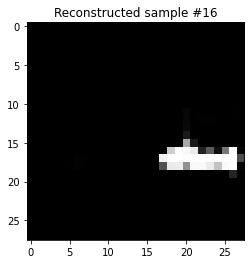

Latent code: [ 5.95 -6.   -8.01  2.27 -0.37  2.09 -9.13 -8.42  2.59]


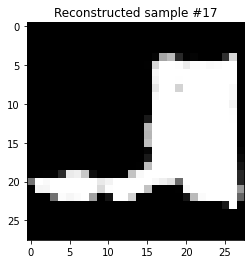

Latent code: [-9.51  5.03  7.04 -6.64 -8.92  3.27  6.77  1.72  5.38]


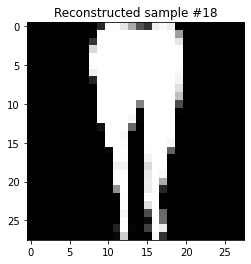

Latent code: [ 9.26 -1.38 -0.96 -9.66 -7.83  9.85  2.42  7.84 -9.67]


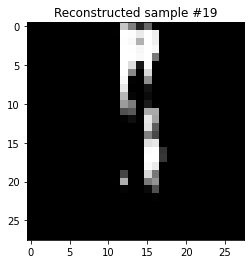

Latent code: [-0.98  1.69  5.    2.   -8.21 -1.96 -0.15 -8.81  9.86]


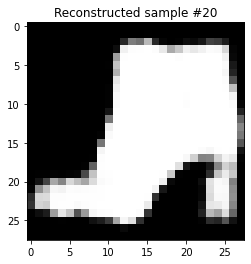

In [45]:
encoded_space_dim = vae.encoded_space_dim
count = 1
for _ in range(20):
    latent_values = [random.uniform(-10, 10) for _ in range(encoded_space_dim)]
    print(f'Latent code: {np.round(latent_values, 2)}')

    custom_values = torch.tensor(latent_values)
    custom_values = custom_values.float().unsqueeze(0).to(device)

    vae.eval()
    with torch.no_grad():
        generated_img = vae.decoder(custom_values)

    generated_img = generated_img.squeeze().cpu().numpy()
    plt.imshow(generated_img, cmap='gist_gray')

    plt.title(f'Reconstructed sample #{count}')
    count += 1
    plt.show()

<a id='9'></a>
[Index](#index)
### 9. Conclusion

In this work we explored different types of autoencoders, a common neural network architecture to solve unsupervised learning tasks, using Zalando's `FashionMNIST` dataset. Performance was evaluated through their reconstruction error. We explored the learned latent space structure via dimensionality-reduction algorithms such as PCA and t-SNE. The reconstruction performances are satisfactory, with the model being able not only to successfully recognize the most prominent features of each wear item but also to characterize some of the subtler details.